# ResNet-18: CIFAR-10 & PyTorch

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 80

### CIFAR-10 data pre-processing

In [7]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4914, 0.4822, 0.4465),
        std = (0.0305, 0.0296, 0.0342)),
     ]
)

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4942, 0.4846, 0.4498),
        std = (0.0304, 0.0295, 0.0342)),
     ]
)

In [8]:
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = 256,
    shuffle = True
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = 256,
    shuffle = True
    )

In [10]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 196 & len(test_loader) = 40


In [12]:
len(train_dataset) / 256, len(test_dataset) / 256

(195.3125, 39.0625)

In [ ]:
def calculate_mean_stddev(data_loader):
    '''
    Compute mean and standard-deviation across all channels for the input
    data loader.
    '''
    # VAR(X) = E(X^2) - E(X) ^ 2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in data_loader:
        channels_sum += torch.mean(data, dim = [0, 2, 3])
        # We don't want mean across channels (1st dimension), hence it is ignored.
        
        channels_squared_sum += torch.mean(data ** 2, dim = [0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std_dev = (channels_squared_sum / num_batches - (mean ** 2)) * 0.5
    # You cannot sum the standard deviation as it is not a linear operation.
    
    return mean, std_dev


In [ ]:
# mean_train, std_dev_train = calculate_mean_stddev(data_loader = train_loader)

In [ ]:
# mean_test, std_dev_test = calculate_mean_stddev(data_loader = test_loader)

In [ ]:
# print(f"CIFAR-10 train dataset: mean = {mean_train} & std-dev = {std_dev_train}")
# print(f"CIFAR-10 train dataset: mean = {mean_test} & std-dev = {std_dev_test}")

# Ignore this due to data augmentations which do not reflect the true data statistics!

### Define _ResNet-18_ CNN architecture

In [13]:
class ResNet_Block(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = F.relu(self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [14]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        return x



In [15]:
# Initialize ResNet-18 architecture-
model = ResNet18().to(device)

In [16]:
# Sanity check-
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [17]:
x.shape, y.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [18]:
out = model(x)

In [19]:
out.shape

torch.Size([256, 512])

In [20]:
del x, y, out

In [21]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128, 128, 3

In [22]:
print(f"Total number of parameters in ResNet-18 CNN = {tot_params}")

Total number of parameters in ResNet-18 CNN = 11168832


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [ ]:
# Save random initial weights-
# torch.save(model.state_dict(), 'ResNet18_random_weights.pth')

# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 32 epochs, or, 6250 steps - until 43rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 4882 steps - until 68th epoch, use lr = 0.01.

- For remaining epochs (13 epochs), use lr = 0.001.

In [23]:
boundaries = [6250, 11132]
values = [0.1, 0.01, 0.001]

In [24]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [25]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [26]:
def decay_function(step, boundaries = [6250, 11132], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [27]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [28]:
# Initial linear LR warmup: 195.3125 x 13 = 2549 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2539,
    decay_func = decay_function
)

In [29]:
step = 0

In [30]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [31]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [32]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

In [33]:
# Initialize parameters saving 'best' models-
best_val_loss = 100
loc_patience = 0

In [34]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(model, train_loader)
    val_loss, val_acc = test_model_progress(model, test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_best_model.pth")
        

Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.05batch/s, val_acc=12.6, val_loss=4.2]



epoch: 1 training loss = 4.4880, training accuracy = 14.21%, val_loss = 4.1957, val_accuracy = 12.58% & LR = 0.0077

Saving model with lowest val_loss = 4.1957



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=26.9, val_loss=2.69]



epoch: 2 training loss = 2.4922, training accuracy = 27.52%, val_loss = 2.6890, val_accuracy = 26.93% & LR = 0.0154

Saving model with lowest val_loss = 2.6890



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=42.3, val_loss=1.88]



epoch: 3 training loss = 2.1685, training accuracy = 34.31%, val_loss = 1.8820, val_accuracy = 42.32% & LR = 0.0231

Saving model with lowest val_loss = 1.8820



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=48.7, val_loss=1.76]



epoch: 4 training loss = 1.9535, training accuracy = 40.91%, val_loss = 1.7640, val_accuracy = 48.70% & LR = 0.0308

Saving model with lowest val_loss = 1.7640



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.06batch/s, val_acc=49.4, val_loss=1.96]



epoch: 5 training loss = 1.7279, training accuracy = 48.06%, val_loss = 1.9610, val_accuracy = 49.36% & LR = 0.0386



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=56.6, val_loss=1.89]



epoch: 6 training loss = 1.5753, training accuracy = 53.29%, val_loss = 1.8909, val_accuracy = 56.65% & LR = 0.0463



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.05batch/s, val_acc=63.9, val_loss=1.25]



epoch: 7 training loss = 1.4450, training accuracy = 57.58%, val_loss = 1.2546, val_accuracy = 63.90% & LR = 0.0540

Saving model with lowest val_loss = 1.2546



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.07batch/s, val_acc=54.8, val_loss=1.76]



epoch: 8 training loss = 1.3439, training accuracy = 60.70%, val_loss = 1.7612, val_accuracy = 54.83% & LR = 0.0617



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=60.6, val_loss=1.71]



epoch: 9 training loss = 1.2673, training accuracy = 63.25%, val_loss = 1.7128, val_accuracy = 60.60% & LR = 0.0694



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.08batch/s, val_acc=68.2, val_loss=1.3]



epoch: 10 training loss = 1.1951, training accuracy = 65.32%, val_loss = 1.3021, val_accuracy = 68.16% & LR = 0.0772



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.06batch/s, val_acc=70.8, val_loss=1.04]



epoch: 11 training loss = 1.1216, training accuracy = 67.68%, val_loss = 1.0358, val_accuracy = 70.77% & LR = 0.0849

Saving model with lowest val_loss = 1.0358



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.01batch/s, val_acc=69.9, val_loss=1.22]



epoch: 12 training loss = 1.0565, training accuracy = 69.68%, val_loss = 1.2223, val_accuracy = 69.93% & LR = 0.0926



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.97batch/s, val_acc=76.8, val_loss=0.875]



epoch: 13 training loss = 1.0055, training accuracy = 71.60%, val_loss = 0.8748, val_accuracy = 76.82% & LR = 0.1000

Saving model with lowest val_loss = 0.8748



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.99batch/s, val_acc=69.7, val_loss=1.19]



epoch: 14 training loss = 0.9732, training accuracy = 72.64%, val_loss = 1.1860, val_accuracy = 69.71% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.07batch/s, val_acc=77.5, val_loss=0.811]



epoch: 15 training loss = 0.9165, training accuracy = 74.26%, val_loss = 0.8109, val_accuracy = 77.54% & LR = 0.1000

Saving model with lowest val_loss = 0.8109



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=76.1, val_loss=0.939]



epoch: 16 training loss = 0.8747, training accuracy = 75.29%, val_loss = 0.9386, val_accuracy = 76.10% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.12batch/s, val_acc=76.8, val_loss=0.888]



epoch: 17 training loss = 0.8597, training accuracy = 76.00%, val_loss = 0.8880, val_accuracy = 76.83% & LR = 0.1000



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.10batch/s, val_acc=70.9, val_loss=1.17]



epoch: 18 training loss = 0.8269, training accuracy = 77.05%, val_loss = 1.1727, val_accuracy = 70.94% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=78, val_loss=0.819]



epoch: 19 training loss = 0.8034, training accuracy = 77.60%, val_loss = 0.8187, val_accuracy = 78.04% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=79.5, val_loss=0.765]



epoch: 20 training loss = 0.8004, training accuracy = 77.66%, val_loss = 0.7647, val_accuracy = 79.45% & LR = 0.1000

Saving model with lowest val_loss = 0.7647



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.02batch/s, val_acc=75.1, val_loss=1.01]



epoch: 21 training loss = 0.7684, training accuracy = 78.61%, val_loss = 1.0060, val_accuracy = 75.06% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.99batch/s, val_acc=82.4, val_loss=0.672]



epoch: 22 training loss = 0.7737, training accuracy = 78.73%, val_loss = 0.6717, val_accuracy = 82.38% & LR = 0.1000

Saving model with lowest val_loss = 0.6717



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.09batch/s, val_acc=82.6, val_loss=0.65]



epoch: 23 training loss = 0.7629, training accuracy = 78.98%, val_loss = 0.6499, val_accuracy = 82.59% & LR = 0.1000

Saving model with lowest val_loss = 0.6499



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.98batch/s, val_acc=74.1, val_loss=1.09]



epoch: 24 training loss = 0.7440, training accuracy = 79.47%, val_loss = 1.0943, val_accuracy = 74.13% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=80.5, val_loss=0.743]



epoch: 25 training loss = 0.7466, training accuracy = 79.53%, val_loss = 0.7431, val_accuracy = 80.53% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.10batch/s, val_acc=82.2, val_loss=0.705]



epoch: 26 training loss = 0.7292, training accuracy = 79.97%, val_loss = 0.7054, val_accuracy = 82.25% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.96batch/s, val_acc=82, val_loss=0.68]



epoch: 27 training loss = 0.7299, training accuracy = 80.00%, val_loss = 0.6799, val_accuracy = 81.97% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.10batch/s, val_acc=80.5, val_loss=0.794]



epoch: 28 training loss = 0.7257, training accuracy = 80.00%, val_loss = 0.7937, val_accuracy = 80.45% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.46batch/s, val_acc=80.2, val_loss=0.759]



epoch: 29 training loss = 0.6986, training accuracy = 80.62%, val_loss = 0.7589, val_accuracy = 80.22% & LR = 0.1000



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.42batch/s, val_acc=73.6, val_loss=1.31]



epoch: 30 training loss = 0.7061, training accuracy = 80.60%, val_loss = 1.3056, val_accuracy = 73.59% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.42batch/s, val_acc=80.9, val_loss=0.713]



epoch: 31 training loss = 0.6951, training accuracy = 80.81%, val_loss = 0.7130, val_accuracy = 80.86% & LR = 0.1000



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.59batch/s, val_acc=88.3, val_loss=0.431]



epoch: 32 training loss = 0.6876, training accuracy = 81.19%, val_loss = 0.4313, val_accuracy = 88.31% & LR = 0.0100

Saving model with lowest val_loss = 0.4313



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.36batch/s, val_acc=90.2, val_loss=0.355]



epoch: 33 training loss = 0.5003, training accuracy = 86.06%, val_loss = 0.3547, val_accuracy = 90.21% & LR = 0.0100

Saving model with lowest val_loss = 0.3547



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.37batch/s, val_acc=90.7, val_loss=0.344]



epoch: 34 training loss = 0.4382, training accuracy = 87.79%, val_loss = 0.3443, val_accuracy = 90.70% & LR = 0.0100

Saving model with lowest val_loss = 0.3443



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.38batch/s, val_acc=90.9, val_loss=0.344]



epoch: 35 training loss = 0.4106, training accuracy = 88.67%, val_loss = 0.3439, val_accuracy = 90.88% & LR = 0.0100

Saving model with lowest val_loss = 0.3439



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.12batch/s, val_acc=91.3, val_loss=0.333]



epoch: 36 training loss = 0.3994, training accuracy = 89.11%, val_loss = 0.3332, val_accuracy = 91.34% & LR = 0.0100

Saving model with lowest val_loss = 0.3332



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.16batch/s, val_acc=91.2, val_loss=0.334]



epoch: 37 training loss = 0.3860, training accuracy = 89.53%, val_loss = 0.3339, val_accuracy = 91.20% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.15batch/s, val_acc=91.3, val_loss=0.347]



epoch: 38 training loss = 0.3778, training accuracy = 89.73%, val_loss = 0.3470, val_accuracy = 91.29% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=91.1, val_loss=0.348]



epoch: 39 training loss = 0.3591, training accuracy = 90.16%, val_loss = 0.3485, val_accuracy = 91.09% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=91.3, val_loss=0.348]



epoch: 40 training loss = 0.3610, training accuracy = 90.25%, val_loss = 0.3485, val_accuracy = 91.28% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.13batch/s, val_acc=91.5, val_loss=0.338]



epoch: 41 training loss = 0.3499, training accuracy = 90.54%, val_loss = 0.3384, val_accuracy = 91.52% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.15batch/s, val_acc=91.4, val_loss=0.347]



epoch: 42 training loss = 0.3382, training accuracy = 90.77%, val_loss = 0.3467, val_accuracy = 91.41% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=91.1, val_loss=0.358]



epoch: 43 training loss = 0.3333, training accuracy = 90.95%, val_loss = 0.3576, val_accuracy = 91.06% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.12batch/s, val_acc=91.5, val_loss=0.339]



epoch: 44 training loss = 0.3309, training accuracy = 91.09%, val_loss = 0.3387, val_accuracy = 91.51% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.16batch/s, val_acc=91.6, val_loss=0.349]



epoch: 45 training loss = 0.3182, training accuracy = 91.21%, val_loss = 0.3494, val_accuracy = 91.60% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=91.4, val_loss=0.348]



epoch: 46 training loss = 0.3196, training accuracy = 91.36%, val_loss = 0.3483, val_accuracy = 91.39% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.67batch/s, val_acc=91.8, val_loss=0.346]



epoch: 47 training loss = 0.3123, training accuracy = 91.47%, val_loss = 0.3458, val_accuracy = 91.83% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.65batch/s, val_acc=91.5, val_loss=0.348]



epoch: 48 training loss = 0.3003, training accuracy = 91.90%, val_loss = 0.3477, val_accuracy = 91.52% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.65batch/s, val_acc=91.7, val_loss=0.344]



epoch: 49 training loss = 0.3007, training accuracy = 91.86%, val_loss = 0.3438, val_accuracy = 91.68% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.60batch/s, val_acc=91.9, val_loss=0.346]



epoch: 50 training loss = 0.3016, training accuracy = 91.95%, val_loss = 0.3458, val_accuracy = 91.87% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.69batch/s, val_acc=91.6, val_loss=0.341]



epoch: 51 training loss = 0.2950, training accuracy = 92.13%, val_loss = 0.3412, val_accuracy = 91.60% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.73batch/s, val_acc=91.8, val_loss=0.349]



epoch: 52 training loss = 0.2945, training accuracy = 92.12%, val_loss = 0.3490, val_accuracy = 91.79% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.79batch/s, val_acc=91.7, val_loss=0.357]



epoch: 53 training loss = 0.2835, training accuracy = 92.37%, val_loss = 0.3567, val_accuracy = 91.69% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.75batch/s, val_acc=91.5, val_loss=0.358]



epoch: 54 training loss = 0.2830, training accuracy = 92.35%, val_loss = 0.3584, val_accuracy = 91.51% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.78batch/s, val_acc=92.2, val_loss=0.327]



epoch: 55 training loss = 0.2782, training accuracy = 92.48%, val_loss = 0.3266, val_accuracy = 92.24% & LR = 0.0100

Saving model with lowest val_loss = 0.3266



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.75batch/s, val_acc=91.5, val_loss=0.374]



epoch: 56 training loss = 0.2842, training accuracy = 92.25%, val_loss = 0.3737, val_accuracy = 91.53% & LR = 0.0100



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.78batch/s, val_acc=92.3, val_loss=0.336]



epoch: 57 training loss = 0.2664, training accuracy = 92.88%, val_loss = 0.3362, val_accuracy = 92.27% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.18batch/s, val_acc=92.5, val_loss=0.318]



epoch: 58 training loss = 0.2297, training accuracy = 93.77%, val_loss = 0.3179, val_accuracy = 92.47% & LR = 0.0010

Saving model with lowest val_loss = 0.3179



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.16batch/s, val_acc=92.8, val_loss=0.318]



epoch: 59 training loss = 0.2174, training accuracy = 94.08%, val_loss = 0.3181, val_accuracy = 92.83% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.18batch/s, val_acc=93, val_loss=0.315]



epoch: 60 training loss = 0.2110, training accuracy = 94.35%, val_loss = 0.3145, val_accuracy = 92.96% & LR = 0.0010

Saving model with lowest val_loss = 0.3145



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.16batch/s, val_acc=92.8, val_loss=0.315]



epoch: 61 training loss = 0.2044, training accuracy = 94.46%, val_loss = 0.3151, val_accuracy = 92.83% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.17batch/s, val_acc=92.9, val_loss=0.316]



epoch: 62 training loss = 0.1983, training accuracy = 94.58%, val_loss = 0.3156, val_accuracy = 92.89% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.18batch/s, val_acc=93.1, val_loss=0.318]



epoch: 63 training loss = 0.1995, training accuracy = 94.64%, val_loss = 0.3180, val_accuracy = 93.08% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.08batch/s, val_acc=93.1, val_loss=0.315]



epoch: 64 training loss = 0.2020, training accuracy = 94.66%, val_loss = 0.3150, val_accuracy = 93.12% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.18batch/s, val_acc=92.9, val_loss=0.318]



epoch: 65 training loss = 0.1994, training accuracy = 94.56%, val_loss = 0.3179, val_accuracy = 92.89% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.19batch/s, val_acc=92.9, val_loss=0.317]



epoch: 66 training loss = 0.1994, training accuracy = 94.65%, val_loss = 0.3167, val_accuracy = 92.94% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.25batch/s, val_acc=93.1, val_loss=0.312]



epoch: 67 training loss = 0.1948, training accuracy = 94.78%, val_loss = 0.3118, val_accuracy = 93.14% & LR = 0.0010

Saving model with lowest val_loss = 0.3118



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.02batch/s, val_acc=93, val_loss=0.316]



epoch: 68 training loss = 0.1886, training accuracy = 94.93%, val_loss = 0.3156, val_accuracy = 93.03% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.10batch/s, val_acc=93, val_loss=0.316]



epoch: 69 training loss = 0.1815, training accuracy = 94.99%, val_loss = 0.3165, val_accuracy = 93.01% & LR = 0.0010



Validation: : 100%|███████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.70batch/s, val_acc=93, val_loss=0.32]



epoch: 70 training loss = 0.1857, training accuracy = 95.00%, val_loss = 0.3203, val_accuracy = 93.01% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.15batch/s, val_acc=92.9, val_loss=0.321]



epoch: 71 training loss = 0.1833, training accuracy = 95.09%, val_loss = 0.3209, val_accuracy = 92.88% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=93.1, val_loss=0.321]



epoch: 72 training loss = 0.1866, training accuracy = 95.05%, val_loss = 0.3213, val_accuracy = 93.06% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.16batch/s, val_acc=93.2, val_loss=0.325]



epoch: 73 training loss = 0.1790, training accuracy = 95.17%, val_loss = 0.3249, val_accuracy = 93.20% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.19batch/s, val_acc=93.3, val_loss=0.318]



epoch: 74 training loss = 0.1803, training accuracy = 95.24%, val_loss = 0.3184, val_accuracy = 93.32% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=93.1, val_loss=0.327]



epoch: 75 training loss = 0.1797, training accuracy = 95.24%, val_loss = 0.3267, val_accuracy = 93.13% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.16batch/s, val_acc=93.3, val_loss=0.32]



epoch: 76 training loss = 0.1771, training accuracy = 95.23%, val_loss = 0.3199, val_accuracy = 93.26% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.08batch/s, val_acc=93.2, val_loss=0.328]



epoch: 77 training loss = 0.1749, training accuracy = 95.32%, val_loss = 0.3281, val_accuracy = 93.25% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=93, val_loss=0.326]



epoch: 78 training loss = 0.1764, training accuracy = 95.25%, val_loss = 0.3257, val_accuracy = 92.99% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.11batch/s, val_acc=93.2, val_loss=0.328]



epoch: 79 training loss = 0.1708, training accuracy = 95.41%, val_loss = 0.3276, val_accuracy = 93.20% & LR = 0.0010



Validation: : 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.63batch/s, val_acc=93.2, val_loss=0.33]


epoch: 80 training loss = 0.1715, training accuracy = 95.35%, val_loss = 0.3296, val_accuracy = 93.19% & LR = 0.0010



In [35]:
print(f"Finished training ResNet-18 CNN on CIFAR-10 dataset")

Finished training ResNet-18 CNN on CIFAR-10 dataset


In [36]:
# Save model from last training epoch-
torch.save(model.state_dict(), "ResNet18_last_epoch_model.pth")

In [37]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [38]:
del model

In [39]:
# Initialize and load 'best' trained parameters from above-
best_trained_model = ResNet18().to(device)
best_trained_model.load_state_dict(torch.load('ResNet18_best_model.pth'))

<All keys matched successfully>

In [40]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(best_trained_model, test_loader)

Validation: : 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 23.02batch/s, val_acc=93.1, val_loss=0.312]


In [41]:
print(f"ResNet-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-18 'best' model metrics: val_loss = 0.3118 & val_acc = 93.14%


In [42]:
del best_trained_model

### ResNet-18 training visualizations

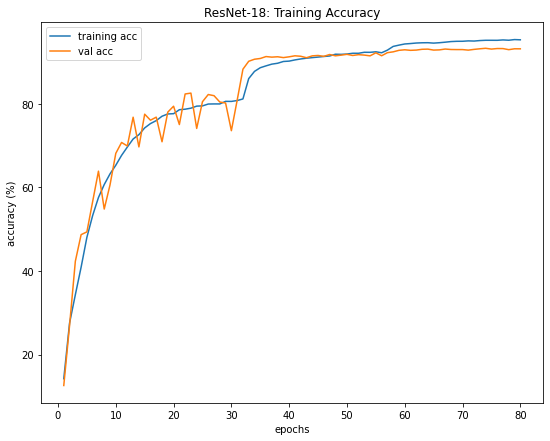

In [43]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

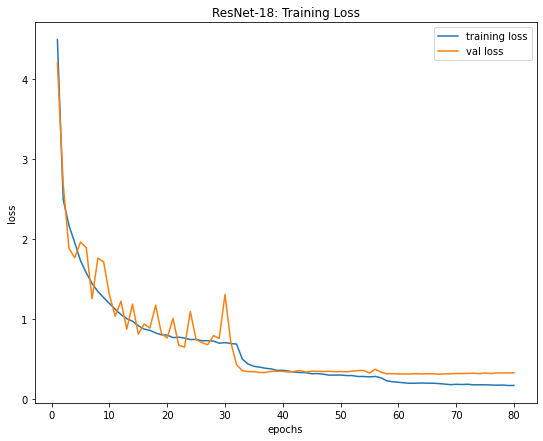

In [44]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: Training Loss")
plt.show()

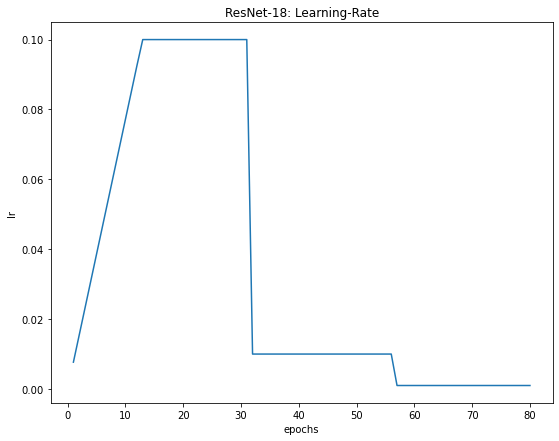

In [45]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()